In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
class TimeSeriesData():
    # generate the data 
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin 
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin)/num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
    
    # a function to check the true value of y for a x value
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    # create batches of data
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        # take a random starting point
        rand_start = np.random.rand(batch_size, 1)
        
        # convert it to be on the time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        # create batch time series on the x axis 
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        
        # create the y data for the time series from previous step 
        y_batch = np.sin(batch_ts)
        
        # formatting for rnn
        if return_batch_ts:
            # send y data(except last column), one shifted version of y data(all but first column), 
            # and also the x axis information
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            # send y data(all except last column), one shifted version of y data(all but first column)
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [3]:
ts_data = TimeSeriesData(250, 0, 10)

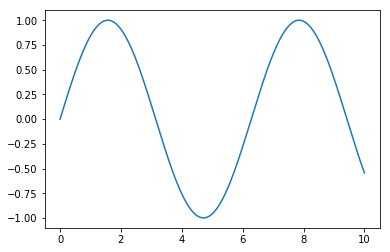

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [5]:
num_time_steps = 50

In [6]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

In [7]:
ts.flatten().shape

(51,)

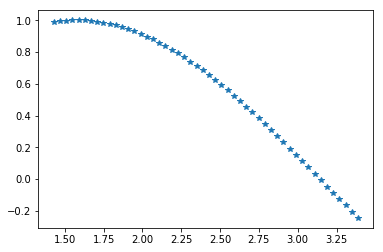

In [8]:
plt.plot(ts.flatten()[:-1], y1.flatten(), '*')

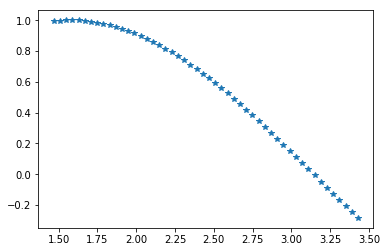

In [9]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

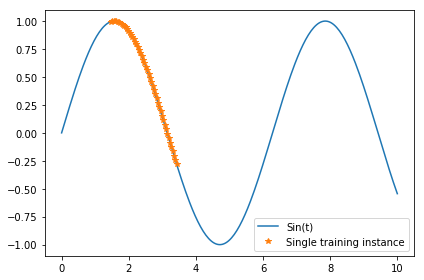

In [10]:
# plot this training instance over original graph 

plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single training instance')

plt.legend()
plt.tight_layout() # if legend is blocking the view

In [11]:
train_inst = np.linspace(1, 1 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

In [12]:
train_inst

array([1.    , 1.0408, 1.0816, 1.1224, 1.1632, 1.204 , 1.2448, 1.2856,
       1.3264, 1.3672, 1.408 , 1.4488, 1.4896, 1.5304, 1.5712, 1.612 ,
       1.6528, 1.6936, 1.7344, 1.7752, 1.816 , 1.8568, 1.8976, 1.9384,
       1.9792, 2.02  , 2.0608, 2.1016, 2.1424, 2.1832, 2.224 , 2.2648,
       2.3056, 2.3464, 2.3872, 2.428 , 2.4688, 2.5096, 2.5504, 2.5912,
       2.632 , 2.6728, 2.7136, 2.7544, 2.7952, 2.836 , 2.8768, 2.9176,
       2.9584, 2.9992, 3.04  ])

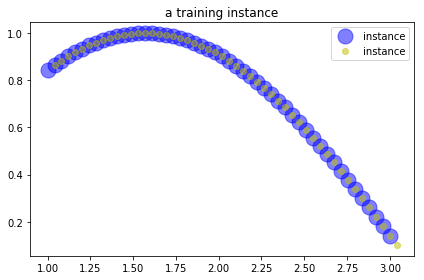

In [13]:
# visualizing what actually we want to predict
plt.title('a training instance')
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', alpha=0.5, markersize=15, label='instance')
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'yo',alpha=0.5, label='instance')

plt.tight_layout()
plt.legend()

# creating the model

In [14]:
# might come across some bug when working with a gpu
tf.reset_default_graph()

In [15]:
num_inputs = 1  # only one feature

In [16]:
num_neurons = 20

In [17]:
num_outputs = 1

In [18]:
learning_rate = 0.0001

In [19]:
num_train_iterations = 2000

In [20]:
batch_size = 1

In [21]:
# placeholder 
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [22]:
# working with a basic rnn cell

# rnn cell layer 

# we have 100 neurons, but we want just one predicted time series output
# so we use a output projection wrapper to project it
# cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu), output_size=num_outputs)
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu), output_size=num_outputs)

In [23]:
# to get the output and state of the rnn cell 
outputs, state = tf.nn.dynamic_rnn(cell=cell, inputs=x, dtype=tf.float32) # Creates a recurrent neural network specified by RNNCell `cell`.

In [24]:
# mse 
loss = tf.reduce_mean(tf.square(outputs - y))

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [26]:
train = optimizer.minimize(loss=loss)

In [27]:
init = tf.global_variables_initializer()

In [28]:
# there might be a slight bug where all the gpu memory is exhausted and program crashes
# workaround : mention the fraction that can be used 
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [29]:
saver = tf.train.Saver()

In [30]:
with tf.Session(config=tf.ConfigProto(gpu_options = gpu_options)) as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations): 
        
        x_batch, y_batch = ts_data.next_batch(batch_size=batch_size, steps=num_time_steps)
        
        sess.run(train, feed_dict={x:x_batch, y:y_batch})
        
        if iteration%100 == 0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            print(iteration, '\t MSE:', mse)
            
    saver.save(sess=sess, save_path='./rnn_time_series_model_codealong')
        

0 	 MSE: 0.29755673
100 	 MSE: 0.24408492
200 	 MSE: 0.22063418
300 	 MSE: 0.2950997
400 	 MSE: 0.12544888
500 	 MSE: 0.08406436
600 	 MSE: 0.15997228
700 	 MSE: 0.13410763
800 	 MSE: 0.12375105
900 	 MSE: 0.06651005
1000 	 MSE: 0.1255542
1100 	 MSE: 0.097355545
1200 	 MSE: 0.06765747
1300 	 MSE: 0.06448944
1400 	 MSE: 0.034288913
1500 	 MSE: 0.024883633
1600 	 MSE: 0.0067516244
1700 	 MSE: 0.008916152
1800 	 MSE: 0.044501524
1900 	 MSE: 0.11349521


In [31]:
with tf.Session() as sess:
    
    saver.restore(sess, './rnn_time_series_model_codealong')
    
    x_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={x:x_new})
    

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


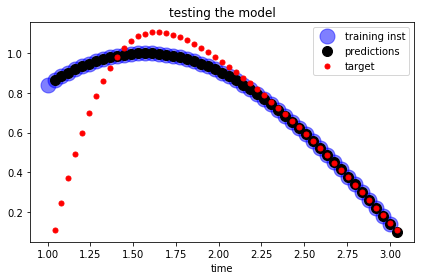

In [32]:
plt.title('testing the model')

# training instance 
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15, label='training inst', alpha=0.5)

# predict(correct test values)
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', label='predictions', markersize=10)

# model actual prediction 
plt.plot(train_inst[1:], y_pred[0, :, 0], 'r.', markersize=10, label='target')

plt.xlabel('time')
plt.legend()
plt.tight_layout()
plt.show()

# generating a new sequence 

In [33]:
with tf.Session() as sess:
    
    saver.restore(sess, './rnn_time_series_model_codealong')
    
    # seed zeros 
    zero_seq_seed = [0.0 for i in range (num_time_steps)]
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        
        x_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={x:x_batch})
        
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


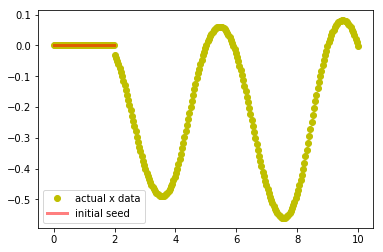

In [48]:
plt.plot(ts_data.x_data, zero_seq_seed, 'yo', label='actual x data')

plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], 'r', linewidth=3, alpha=0.5, label='initial seed')

plt.legend()

In [44]:
# trying a different seed which is actually on sin curve

with tf.Session() as sess:
    
    saver.restore(sess, './rnn_time_series_model_codealong')
    
    # seed zeros 
    training_instance = list (ts_data.y_true[:num_time_steps]) 
    
    for iteration in range(len(training_instance) - num_time_steps):
        
        x_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={x:x_batch})
        
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


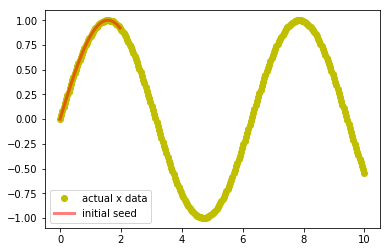

In [46]:
plt.plot(ts_data.x_data, ts_data.y_true, 'yo', label='actual x data')

plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], 'r', linewidth=3, alpha=0.5, label='initial seed')

plt.legend()